## EXECUTIVE SUMMARY

- Users expect LLMs to retain conversation history for context-aware responses.  
- This is typically achieved by appending past exchanges to the context window.  
- OpenAI's Responses API simplifies this by using `previous_response_id` to maintain memory.  
- However, it incurs higher token costs as all prior inputs in the chain are billed.  
- This can be expensive for enterprises as conversations grow longer.  
- A better approach is using a RAG system to embed and retrieve relevant interactions, avoiding full conversation replay.  

In [ ]:
from dotenv import load_dotenv
from openai import OpenAI
import matplotlib.pyplot as plt

# Get OPENAI_API_KEY from .env file
load_dotenv()
client = OpenAI()

In [98]:
# Define prompts to be used in the notebook
prompts = [
    "Hi, my name is John.",
    "My surname is Smith.",
    "I am 25 years old.",
    "I live in New York.",
    "I love programming.",
]

# Define the model to be used
model = "gpt-4o-mini"

## OpenAI CHAT Completions API is Stateless
(It doesn't retain information about your past interactions with the model) 

In [99]:
response = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "developer",
            "content": "You are an amazing assistant that gives very succinct responses.",
        },
        {"role": "user", "content": prompts[0]},
    ],
)

response.choices[0].message.content

'Hi John! How can I assist you today?'

In [100]:
response = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "developer",
            "content": "You are an amazing assistant that gives very succinct responses.",
        },
        {"role": "user", "content": "What is my name?"},
    ],
)

response.choices[0].message.content

"I don't know your name."

- As expected, the model did not retain our past conversation

## Make Chat Completions Stateful 
Let's add past conversation history when generating new output

In [101]:
conversation = []
for prompt in prompts:

    ## Add the developer message to the messages list
    messages = [
        {
            "role": "developer",
            "content": "You are an amazing assistant that gives very succinct responses.",
        },
    ]

    ## Add previous exchanges to the messages list
    for exchange in conversation:
        messages.append(
            {
                "role": "user",
                "content": exchange["prompt"],
            }
        )
        messages.append(
            {
                "role": "assistant",
                "content": exchange["response"]["choices"][0]["message"]["content"],
            }
        )

    ## Add the current prompt to the messages list
    messages.append(
        {
            "role": "user",
            "content": f"{prompt} Briefly describe what you know about me.",
        }
    )

    ## Call the API
    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )

    ## Add to conversation
    conversation.append({"prompt": prompt, "response": response.to_dict()})

    ## Display the prompt and response
    print(f"Prompt: {prompt}\nResponse: {response.choices[0].message.content}\n\n")

Prompt: Hi, my name is John.
Response: Hi John! I don’t have any specific information about you apart from your name. How can I assist you today?


Prompt: My surname is Smith.
Response: I only know your name is John Smith. I don’t have any other information. How can I help you today?


Prompt: I am 25 years old.
Response: You are John Smith, 25 years old. How can I assist you further?


Prompt: I live in New York.
Response: You are John Smith, 25 years old, and you live in New York. How can I help you today?


Prompt: I love programming.
Response: You are John Smith, 25 years old, living in New York, and you love programming. How can I assist you?




- We can see that this kind of chaining helps remember past exhanges. However it also increases the number of tokens. Let's see how the input token increases from prompt to prompt

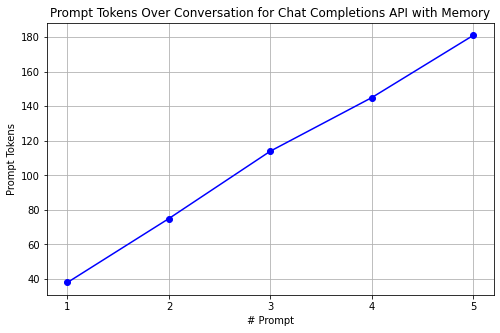

In [ ]:
# Extract prompt tokens from the conversation
token_counts_chat_completion = [
    exchange["response"]["usage"]["prompt_tokens"]
    for exchange in conversation
]


# Plot the prompt tokens
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(token_counts_chat_completion) + 1),
    token_counts_chat_completion,
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Prompt Tokens Over Conversation for Chat Completions API with Memory")
plt.xlabel("# Prompt")
plt.ylabel("Prompt Tokens")
plt.xticks(
    range(1, len(token_counts_chat_completion) + 1)
)  # Set x-axis labels to integers
plt.grid(True)
plt.show()

- The chaining helps the model remember old exhanges by putting the past conversation in context window. However this is costly as the input token keeps increasing
- Let's try Responses API and see whether it improves this situation

## Try Responses API instead of Chat Completions API
Steps for switching to Responses API from Chat Completions:
1. Replace `client.chat.completions` with `client.responses`
2. Use `input` instead of `messages`

In [104]:
response = client.responses.create(
    model=model,
    input=prompts[0],
)

response.output_text

'Hi John! How can I help you today?'

In [105]:
response = client.responses.create(model = model, input = "What is my name?")

response.output_text

"I don't have access to personal data unless you share it with me. If you'd like to tell me your name, feel free!"

- What? Responses API doesn't retain conversation history?
- Actually, we need to tweak the API call a little bit to feed the latest prompt ID when generating response
- This way, the model has access to the past exhanges

In [106]:
response = client.responses.create(model=model, input=prompts[0])

# Get the response ID from the response object
# This will be used in future prompts
response_id = response.id
response.output_text

'Hi John! How can I assist you today?'

In [107]:
# Let's try whether the memory is retained by feeding previous response ID
response = client.responses.create(
    model=model, input="What is my name?", previous_response_id=response_id
)

response.output_text

'Your name is John. How can I help you today, John?'

- Yaaay! The memory is retained.
- Now let's implement a series of prompts as below

In [108]:
conversation = []
response_id = None
for prompt in prompts:

    ## Call the API
    response = client.responses.create(
        model=model, 
        input=f"{prompt} Briefly describe what you know about me.", 
        previous_response_id=response_id
    )

    response_id = response.id

    ## Add to conversation
    conversation.append({"prompt": prompt, "response": response.to_dict()})

    ## Display the prompt and response
    print(f"Prompt: {prompt}\nResponse: {response.output_text}\n\n")

Prompt: Hi, my name is John.
Response: Hi John! I don't have any information about you beyond what you've just shared. If you'd like me to know more, feel free to tell me about your interests, hobbies, or anything else you'd like to share!


Prompt: My surname is Smith.
Response: I know your name is John Smith, but I still don't have any details about your interests or background. If you share more about yourself, I can provide a better description!


Prompt: I am 25 years old.
Response: You're John Smith, a 25-year-old. That's a bit of your background, but I still don't have details about your interests, hobbies, or experiences. If you share more, I can give a fuller picture!


Prompt: I live in New York.
Response: You're John Smith, a 25-year-old living in New York. That's a vibrant city with plenty of cultural, social, and recreational opportunities. If you'd like to share more about your interests or experiences, I'd love to know!


Prompt: I love programming.
Response: You're John

- Great, the Responses API helps us maintain memory, with less boilerplate code. 
- Let's check how the # prompts is increasin

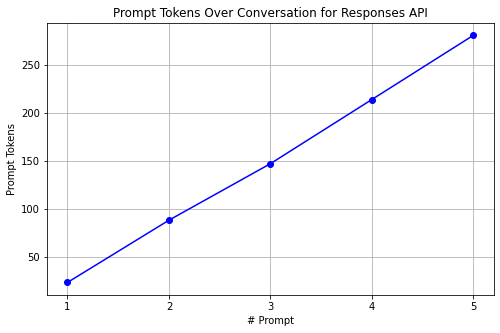

In [109]:
# Extract prompt tokens from the conversation
token_counts_responses = [
    exchange["response"]["usage"]["input_tokens"] for exchange in conversation
]


# Plot the prompt tokens
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(token_counts_responses) + 1),
    token_counts_responses,
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Prompt Tokens Over Conversation for Responses API")
plt.xlabel("# Prompt")
plt.ylabel("Prompt Tokens")
plt.xticks(range(1, len(token_counts_responses) + 1))  # Set x-axis labels to integers
plt.grid(True)
plt.show()

- Let's get 2 plots side by side to compare

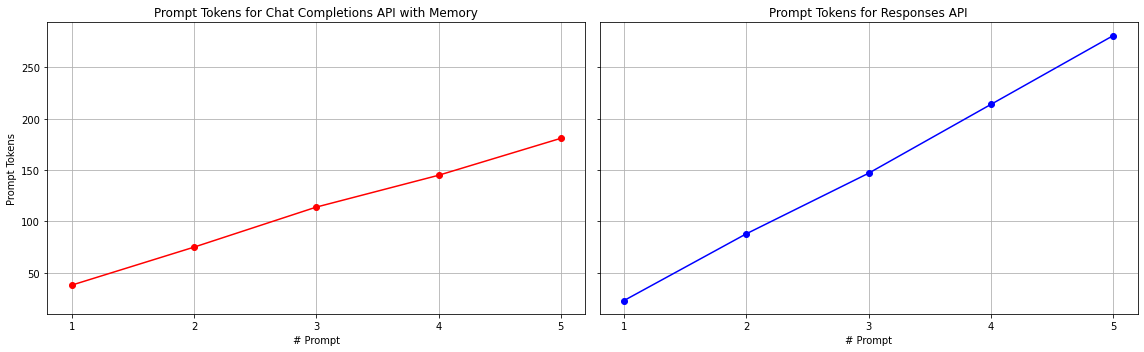

In [111]:
# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Plot for Chat Completions API
axes[0].plot(
    range(1, len(token_counts_chat_completion) + 1),
    token_counts_chat_completion,
    marker="o",
    linestyle="-",
    color="r",
)
axes[0].set_title("Prompt Tokens for Chat Completions API with Memory")
axes[0].set_xlabel("# Prompt")
axes[0].set_ylabel("Prompt Tokens")
axes[0].set_xticks(range(1, len(token_counts_chat_completion) + 1))
axes[0].grid(True)

# Plot for Responses API
axes[1].plot(
    range(1, len(token_counts_responses) + 1),
    token_counts_responses,
    marker="o",
    linestyle="-",
    color="b",
)
axes[1].set_title("Prompt Tokens for Responses API")
axes[1].set_xlabel("# Prompt")
axes[1].set_xticks(range(1, len(token_counts_responses) + 1))
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

- This approach reduces boilerplate code and avoids tracking all past interactions, but the higher number of prompts may increase costs as conversations grow longer.